## ESI at AMO
# Figure: diffraction patterns

In [1]:
%pylab inline
import pickle, os
import condor, spimage, h5py
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


/Users/max.hantke/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Convenience function for reading and local caching of XFEL data from Davinci

In [30]:
davinci_mount = "/Users/max.hantke/davinci"

cache_filename = "./cache.p"
do_clear_cache = False
if not os.path.exists(cache_filename) or do_clear_cache:
    with open(cache_filename, "w") as f:
        pickle.dump({}, f)

def read_data(run, i, i0=0, sort=True):
    if isinstance(i, list):
        i_list = i
    else:
        i_list = [i]
    
    with open(cache_filename, "r") as f:
        C = pickle.load(f)
    
    if run in C:
        R = C[run]
    else:
        R = _read_metadata_from_davinci(run)

    mask = R["mask"]
    images = []
    for _i in i_list:
        if sort:
            _i_ds = R["i_sorted"][i0+_i]
        else:
            _i_ds = i0+_i
        if _i_ds in R["images"]:
            print "Load data from cache"
            img = R["images"][_i_ds]
        else:
            print "Load data from davinci"
            img = _read_image_from_davinci(run, _i_ds)
            R["images"][_i_ds] = img
        images.append(img)
    images = asarray(images)
    
    C[run] = R
    with open(cache_filename, "w") as f:
        pickle.dump(C, f)

    return mask, images
           
data_folder = "/scratch/fhgfs/xray/amol3416/preproc_201707"
#data_folder = "/scratch/fhgfs/xray/amol3416/preproc_201611"
def _read_metadata_from_davinci(run):
    with h5py.File("%s%s/amol3416_r%04i_ol3.h5" % (davinci_mount, data_folder, run), "r") as f:
        mask = array(f["/entry_1/data_1/mask"])
        hitscores = array(f["/entry_1/result_1/hitscore_litpixel"])
        i_sorted = hitscores.argsort()[::-1]
    return {"mask": mask, "i_sorted" : i_sorted, "images": {}}
        
def _read_image_from_davinci(run, i):
    with h5py.File("%s%s/amol3416_r%04i_ol3.h5" % (davinci_mount, data_folder, run), "r") as f:
        image = array(f["/entry_1/data_1/data"][i], dtype="f")/f["entry_1/detector_1/gain"][i]
    return image

## 1) TBSV

### Read data

In [128]:
# TBSV
run_tbsv = 135
i_list_tbsv = [11,12,10,9]
mask_tbsv, images_tbsv = read_data(run_tbsv, i=i_list_tbsv)
Nx = mask_tbsv.shape[1]
Ny = mask_tbsv.shape[0]

Load data from cache
Load data from cache
Load data from cache
Load data from cache


### Simulation

In [129]:
ds_tbsv = 8
edge_length_tbsv = 1024
wl = condor.source.Photon(energy_eV=800.).get_wavelength()
S = condor.Source(wavelength=wl, focus_diameter=3.E-6, pulse_energy=0.05*1E-3)
D_distance = 0.25
D = condor.Detector(distance=D_distance, pixel_size=75E-6, nx=Nx, ny=Ny)

# Single
P1 = condor.ParticleSphere(diameter=35E-9, material_type="cell")#, rotation_formalism='random')
E1 = condor.Experiment(S, {"particle_sphere": P1}, D)
res1 = E1.propagate()
in1 = res1['entry_1']['data_1']['data']
rs1 = spimage.crop(abs(fftshift(ifftn(fftshift(res1['entry_1']['data_1']['data_fourier'])))), 30)
#imshow(in1)

# Double
P2 = condor.ParticleSphere(diameter=35E-9, material_type="cell", position=[0.,0.,0.], position_variation_n=[2,1,1], position_spread=[35E-9,0.,0.], position_variation="range", number=2)
E2 = condor.Experiment(S, {"particle_sphere": P2}, D)
res2 = E2.propagate()
in2 = res2['entry_1']['data_1']['data']
rs2 = spimage.crop(abs(fftshift(ifftn(fftshift(res2['entry_1']['data_1']['data_fourier'])))), 30)
#imshow(in2)

sims_tbsv = [array(poisson(in1), dtype='f'), array(poisson(in2), dtype='f')]
rssims_tbsv = [rs1, rs2]

### Reconstructions

In [114]:
rec11 = zeros(shape=(30,30))
rec12 = zeros(shape=(30,30))
rec21 = zeros(shape=(30,30))
rec22 = zeros(shape=(30,30))

rsrecs_tbsv = [rec11, rec12, rec21, rec22]

## 2) Carboxysomes

### Read data

In [130]:
# CBX
run_cbx = 127
i_list_cbx = [3,4,5,9,10]
mask_cbx, images_cbx = read_data(run_cbx, i=i_list_cbx)
Nx = mask_cbx.shape[1]
Ny = mask_cbx.shape[0]

Load data from cache
Load data from cache
Load data from cache
Load data from cache
Load data from cache


### Simulation

In [131]:
ds_cbx = 8
edge_length_cbx = 700
wl = condor.source.Photon(energy_eV=800.).get_wavelength()
S = condor.Source(wavelength=wl, focus_diameter=3.E-6, pulse_energy=0.05*1E-3)
D = condor.Detector(distance=0.250, pixel_size=75E-6, nx=Nx, ny=Ny)
PI = condor.ParticleMap(diameter=100E-9, material_type="cell", geometry="icosahedron", rotation_formalism='random')
EI = condor.Experiment(S, {"particle_map": PI}, D)
resI = EI.propagate()
inI = resI['entry_1']['data_1']['data']
rsI = spimage.crop(abs(fftshift(ifftn(fftshift(resI['entry_1']['data_1']['data_fourier'])))), 30)
sims_cbx = [array(poisson(inI), dtype='f'), array(poisson(inI), dtype='f')]
rssims_cbx = [rsI, rsI]
#imshow(log10(poisson(abs(inI))))

### Reconstructions

In [132]:
rec11 = zeros(shape=(30,30))
rec12 = zeros(shape=(30,30))
rec21 = zeros(shape=(30,30))
rec22 = zeros(shape=(30,30))

rsrecs_cbx = [rec11, rec12, rec21, rec22]

### Plot Carboxysomes and TBSV together

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


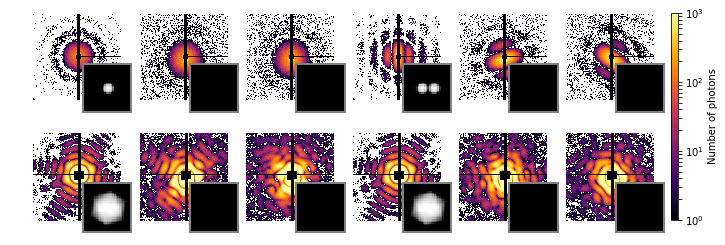

In [148]:
from matplotlib.font_manager import FontProperties
font_b = FontProperties().copy()
font_b.set_weight('bold')
font_n = FontProperties().copy()

sf = 0.5
fw = sf*20
fh = sf*7
fr = fw/fh
fig= figure(figsize=(fw,fh))
Nax = 6
w = 1/float(2.2+Nax)
h = 0.9/2.
x0 = linspace(0.01, 0.75, Nax)
y0 = 0.05/2.

axs1 = [fig.add_axes([x0i,y0+h+y0,w,h]) for x0i in x0]
axs1_is = [fig.add_axes([x0i+w*0.57,2*y0+h-0.02,w*0.55,h*0.55]) for x0i in x0]
axs2 = [fig.add_axes([x0i,y0,w,h]) for x0i in x0]
axs2_is = [fig.add_axes([x0i+w*0.57,y0-0.02,w*0.55,h*0.55]) for x0i in x0]
axc = fig.add_axes([0.75+w*1.2, 0.08, 0.01, 0.9-0.08])

cmap = 'inferno'
for axs, axs_is, images, mask, sims, ds, edge_length in zip([axs1, axs2], [axs1_is, axs2_is],
                                                           [images_tbsv, images_cbx], [mask_tbsv, mask_cbx], [sims_tbsv, sims_cbx],
                                                           [ds_tbsv, ds_cbx], [edge_length_tbsv, edge_length_cbx]):
    
    for ax,_img in zip(axs, [sims[0]] + [images[0]] + [images[1]] + [sims[1]] + [images[2]] + [images[3]]):
        img = _img.copy()
        img[img<0.75] = 0
        msk = mask
        if crop_length is not None:
            img = spimage.crop(img, cropLength=edge_length, center=(512+25, 512))
            msk = spimage.crop(msk, cropLength=edge_length, center=(512+25, 512))
        img, msk = spimage.binImage(img, ds, msk=msk==0, output_binned_mask=True)
        ax.imshow(img, norm=LogNorm(1, 1000), cmap=cmap, interpolation="nearest")
        ax.imshow(log10((1-msk)*10), cmap="binary_r")
        ax.set_axis_off()
colorbar(mappable=im, cax=axc, label="Number of photons")
    
for axs, axs_is, rsrecs, rssims in zip([axs1, axs2], [axs1_is, axs2_is], 
                                       [rsrecs_tbsv, rsrecs_cbx], [rssims_tbsv, rssims_cbx]):
    for ax,data in zip(axs_is, [rssims[0], rsrecs[0], rsrecs[1], rssims[1], rsrecs[2], rsrecs[3]]):
        ax.imshow(data, cmap='binary_r', interpolation='nearest')
        plt.setp(ax.spines.values(), color="gray", lw=2)
        ax.set_xticks([])
        ax.set_yticks([])
    
#axs[0].annotate("a", (0.,1.2), xycoords="axes fraction",ha="right", va="top", fontproperties=font_b)
#axs[0].annotate("Simulation", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
#axs[1].annotate("Measurement", (1.1,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
#axs[3].annotate("b", (0.,1.2), xycoords="axes fraction",ha="right", va="top", fontproperties=font_b)
#axs[3].annotate("Simulation", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
#axs[4].annotate("Measurement", (1.1,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)

#savefig("patterns_tbsv.png", dpi=600)

## 3) Rubisco

### Read data

In [68]:
# Rubisco
run_rub = 150
#i0 = 0
#mask_rub, images_rub = read_data(run_rubisco, N=30, i0=i0, sort=True)